# NLP Project 2 - Anna Zenou and Timothé Vital

## Book recommendation LLM

### Imports

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from textblob import TextBlob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import joblib
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from gensim.models import Word2Vec
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed, parallel_backend
from transformers import pipeline

C:\Users\timot\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Dataset exploration

The Dataset is a gathering of english book reviews from the Goodreads website (https://www.goodreads.com/). 

Each row corresponds to a review written by a user on a specific book

No new API keys are generated for developers so we found a dataset on kaggle, we still have the cleaning and exploration to do

In [358]:
df = pd.read_csv("D:/s9/NLP/projet3/goodreads_reviews/goodreads_train.csv")

In [4]:
df.shape

(900000, 11)

In [5]:
df.head(1)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1


In [360]:
rating_counts = df['rating'].value_counts()
rating_percentages = df['rating'].value_counts(normalize=True) * 100  # Convert to percentage

# Combine counts and percentages into a single DataFrame
rating_summary = pd.DataFrame({'Count': rating_counts, 'Percentage': rating_percentages})

print(rating_summary)

    Count  Percentage
4  313688   34.854222
5  265007   29.445222
3  188972   20.996889
2   72627    8.069667
0   30988    3.443111
1   28718    3.190889


The dataset contains 900 000 unique reviews, we are going to narrow it down for the training of the model

We will use this function when we need to convert a book id into its corresponding title. Converting the whole column for the whole dataset would take hours so we wont apply it to the whole dataframe

In [6]:
# This function opens the page corresponding to the book and scraps the title
def get_book_name(book_id):
    url = f'https://www.goodreads.com/book/show/{book_id}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the element containing the book's name
    title_element = soup.find('h1', {'class': 'Text Text__title1', 'data-testid': 'bookTitle'})
    if title_element:
        return title_element.text.strip()
    else:
        return 'Title not found'

In [8]:
unique_books = df['book_id'].nunique()
print(f"There are {unique_books} different reviewed books in this dataset")

There are 25474 different reviewed books in this dataset


In [9]:
book_counts = df['book_id'].value_counts()
book_counts.head(5)

11870085    1734
11235712    1505
2767052     1378
7260188     1273
16096824    1153
Name: book_id, dtype: int64

### Narrowing down the number of reviews.

We will keep 1000 books that have at least 50 reviews, and keep 50 reviews for each book.

In [10]:
# Step 1: Identify the 1000 most commented (reviewed) books
most_commented_books = df['book_id'].value_counts().head(1000).index

# Filter the original DataFrame to keep only the most commented books
filtered_df = df[df['book_id'].isin(most_commented_books)]

# Step 2: Calculate average ratings for these books
average_ratings = filtered_df.groupby('book_id')['rating'].mean()

# Step 3: Select the top 1000 books based on average ratings
top_books = average_ratings.nlargest(1000)

# Create a DataFrame of the top books and name it selected_reviews
selected_reviews = pd.DataFrame({'book_id': top_books.index, 'average_rating': top_books.values})

In [11]:
selected_reviews.shape

(1000, 2)

In [12]:
# Filter the original DataFrame to keep only the reviews of the selected books
filtered_df = df[df['book_id'].isin(selected_reviews['book_id'])]

# Initialize an empty DataFrame to store the samples
sampled_reviews = pd.DataFrame()

# Sample 50 random comments for each book
for book_id in selected_reviews['book_id']:
    sampled_reviews = pd.concat([sampled_reviews, filtered_df[filtered_df['book_id'] == book_id].sample(n=50, replace=True)])

# Reset index of the final DataFrame
sampled_reviews = sampled_reviews.reset_index(drop=True)

In [13]:
sampled_reviews.shape

(50000, 11)

In [14]:
unique_books = sampled_reviews['book_id'].nunique()
print(f"There are {unique_books} different reviewed books in this dataset")

There are 1000 different reviewed books in this dataset


### We now have 1000 books with 50 reviews each, for a total of 50 000 rows

Ensure the rating column contains numeric values

In [15]:
sampled_reviews['rating'] = pd.to_numeric(sampled_reviews['rating'], errors='coerce')

In [121]:
sampled_reviews.dtypes

user_id                   object
book_id                    int64
review_id                 object
rating                     int64
review_text               object
date_added                object
date_updated              object
read_at                   object
started_at                object
n_votes                    int64
n_comments                 int64
cleaned_text              object
cleaned_text_str          object
limited_text              object
classification_result     object
review_sentiment         float64
dtype: object

### Top 10 Best books by average ratings amongst the top 1000 top books

In [16]:
# Group by book_id, calculate the average rating, and sort the results
top_books = sampled_reviews.groupby('book_id')['rating'].mean().sort_values(ascending=False).head(10)

# Fetch book names for the top 10 books
top_books_names = top_books.index.map(get_book_name)

# Create a DataFrame to display book names and their average ratings
top_books_df = pd.DataFrame({
    'Book Name': top_books_names,
    'Average Rating': top_books.values
})

print("Top 10 Best Books by Average Rating:")
print(top_books_df)

Top 10 Best Books by Average Rating:
                                  Book Name  Average Rating
0  Harry Potter and the Prisoner of Azkaban            4.66
1                         Words of Radiance            4.64
2      Harry Potter and the Deathly Hallows            4.62
3                             Magic Strikes            4.62
4                           The Nightingale            4.62
5                          The Final Empire            4.62
6                           Title not found            4.60
7                                     Night            4.60
8    Harry Potter and the Half-Blood Prince            4.58
9                           A Monster Calls            4.58


### Top 10 worse books

In [120]:
# Group by book_id, calculate the average rating, and sort the results
worse_books = sampled_reviews.groupby('book_id')['rating'].mean().sort_values(ascending=True).head(10)

# Fetch book names for the top 10 books
worse_books_names = worse_books.index.map(get_book_name)

# Create a DataFrame to display book names and their average ratings
worse_books_df = pd.DataFrame({
    'Book Name': worse_books_names,
    'Average Rating': worse_books.values
})

print("Top 10 Worse Books by Average Rating:")
print(worse_books_df)

Top 10 Worse Books by Average Rating:
                         Book Name  Average Rating
0        Twilight / Life and Death            1.76
1  Pride and Prejudice and Zombies            2.32
2             Fifty Shades of Grey            2.32
3             The Glittering Court            2.44
4                          Crossed            2.46
5                          Passion            2.54
6                A Thousand Nights            2.56
7                  Dead Ever After            2.58
8                           Fallen            2.60
9                Go Set a Watchman            2.62


### Rating distribution

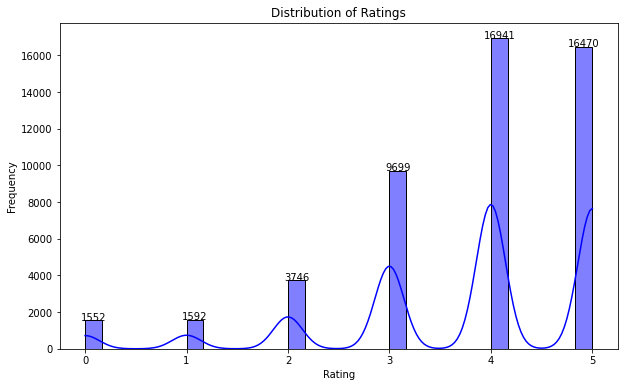

In [17]:
# Distribution of Ratings
plt.figure(figsize=(10, 6))
histplot = sns.histplot(sampled_reviews['rating'].dropna(), kde=True, color='blue', bins=30)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Annotate bins with integer height
for p in histplot.patches:
    height = p.get_height()
    if height.is_integer() and height != 0:  # Check if height is an integer and not zero
        plt.text(p.get_x() + p.get_width() / 2,  # x-coordinate for text
                 height + 3,  # y-coordinate for text
                 f'{int(height)}',  # text
                 ha='center')

plt.show()

### Top 10 Users by votes received (review approvals)

(For Privacy and data protection we are enable to display the exact names so we leave the ids)

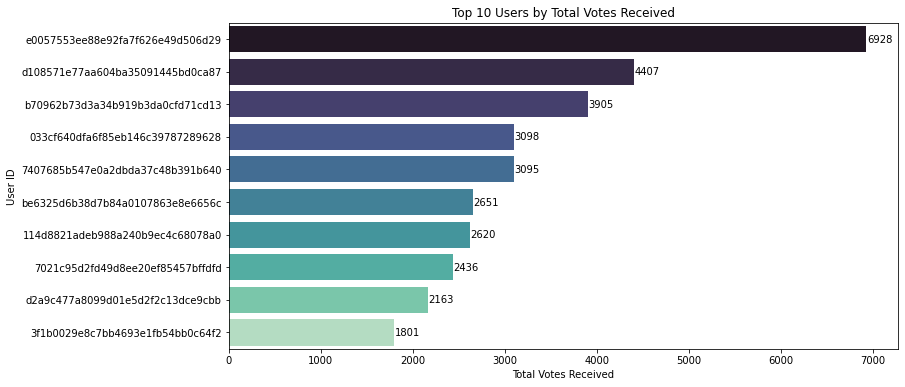

In [18]:
top_voted_reviews = sampled_reviews.groupby('user_id')['n_votes'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=top_voted_reviews.values, y=top_voted_reviews.index, palette='mako')
plt.title('Top 10 Users by Total Votes Received')
plt.xlabel('Total Votes Received')
plt.ylabel('User ID')

# Annotate each bar with the value
for p in barplot.patches:
    width = p.get_width()
    plt.text(width + 5,  # x-coordinate for text
             p.get_y() + p.get_height() / 2,  # y-coordinate for text
             f'{int(width)}',  # text
             va='center')

plt.show()

In [19]:
# Calculate the total average rating across all books
total_average_rating = sampled_reviews['rating'].mean()

print(f"Total Average Rating across all books: {total_average_rating}")

Total Average Rating across all books: 3.7659


### Most and least generous reviewers

In [122]:
# Count the number of comments made by each reviewer
reviewer_comment_count = sampled_reviews['user_id'].value_counts()

# Filter out reviewers with 20 or fewer comments
active_reviewers = reviewer_comment_count[reviewer_comment_count > 20].index

# Filter the original DataFrame to keep only active reviewers
active_reviews = sampled_reviews[sampled_reviews['user_id'].isin(active_reviewers)]

# Calculate the average rating for each active reviewer
reviewer_avg_rating = active_reviews.groupby('user_id')['rating'].mean()

# Sort reviewers by Average Rating and select the top 5
top_reviewers = reviewer_avg_rating.sort_values(ascending=False).head(5)

# Sort reviewers by Average Rating and select the bottom 5
bottom_reviewers = reviewer_avg_rating.sort_values(ascending=True).head(5)

# Create a DataFrame for the top reviewers
top_reviewers_df = pd.DataFrame({
    'Reviewer': top_reviewers.index,
    'Average Rating': top_reviewers.values
})

# Create a DataFrame for the worse reviewers
bottom_reviewers_df = pd.DataFrame({
    'Reviewer': bottom_reviewers.index,
    'Average Rating': bottom_reviewers.values
})

print(f'Amongst the 300 users that have written more than 20 reviews, \n\nTop 5 most generous : \n\n{top_reviewers_df}')
print(f'\nTop 5 least generous : \n\n{bottom_reviewers_df}')

Amongst the 300 users that have written more than 20 reviews, 

Top 5 most generous : 

                           Reviewer  Average Rating
0  e6c197152bdda3a6f0bb1ead74d8d6c8        5.000000
1  3d3c274dfe57506ea763d57438663887        4.818182
2  3693bb4f1062b659a354848cf11ca313        4.730769
3  22e6aa6cb4425438f32a49c7cbcb070a        4.695652
4  a3e696e6ced8daae338eccf12ac58053        4.645161

Top 5 least generous : 

                           Reviewer  Average Rating
0  89792c2c139b39347004d2d8480046f6        0.161290
1  5f4bce05d28ee52cbfefa470cb8fef29        2.095238
2  dd279322f9c25c93351c3ae6a99cccac        2.181818
3  9c832443e883b0fbf613883fd744c6ad        2.360000
4  443bb7f2f5db781e438deb1f680e7996        2.470588


## Data cleaning

### Removing stopwords, ponctuation and numbers

In [410]:
english_stopwords = set(stopwords.words('english'))

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    words = tokenizer.tokenize(text)
    # Remove stopwords
    filtered_words = [word for word in words if word not in english_stopwords]
    return " ".join(filtered_words)

#tqdm.pandas(desc="Cleaning and Correcting Text")
#sampled_reviews['cleaned_text'] = sampled_reviews['review_text'].progress_apply(clean_text)

### Spelling correction

In [35]:
def correct_spelling(text):
    blob = TextBlob(text)
    corrected_text = blob.correct()
    return str(corrected_text)

In [36]:
tqdm.pandas(desc="Correcting spelling")
sampled_reviews['cleaned_text'] = sampled_reviews['cleaned_text'].progress_apply(correct_spelling)

Correcting spelling: 100%|████████████████████████████████████████████████████| 50000/50000 [13:01:27<00:00,  1.07it/s]


Removing the bi grams hide spoiler and show spoiler from the cleaned text becauyse they are useless

In [25]:
sampled_reviews['cleaned_text'] = sampled_reviews['cleaned_text'].str.replace('hide spoiler', '')
sampled_reviews['cleaned_text'] = sampled_reviews['cleaned_text'].str.replace('view spoiler', '')

### Saving the new file with 50 000 rows and cleaned review text

In [37]:
file_path = 'D:/s9/NLP/projet3/goodreads_reviews/sampled_reviews.csv'

# Save the DataFrame to a CSV file
sampled_reviews.to_csv(file_path, index=False)

### Most frequent words and n-grams in raw data

In [50]:
# Function to get top N frequent words with tqdm
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in tqdm(vec.vocabulary_.items(), desc="Processing Words")]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]

# Function to get top N frequent n-grams with tqdm
def get_top_n_grams(corpus, n=None, ngram=2):
    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in tqdm(vec.vocabulary_.items(), desc="Processing N-grams")]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]

### Compare cleaned_text top words and bi grams to uncleaned reviews

#### With raw (uncleaned) reviews : 

In [45]:
top_words_uncleaned = get_top_n_words(sampled_reviews['review_text'], n=10)
top_bigrams_uncleaned = get_top_n_grams(sampled_reviews['review_text'], n=10, ngram=2)

Processing N-grams: 100%|████████████████████████████████████████████████| 1475738/1475738 [00:01<00:00, 889256.10it/s]


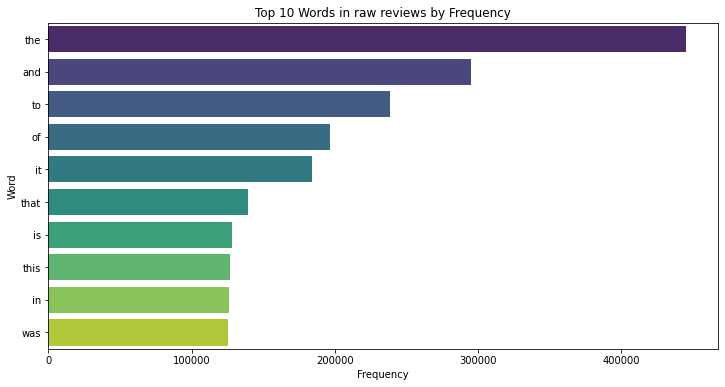

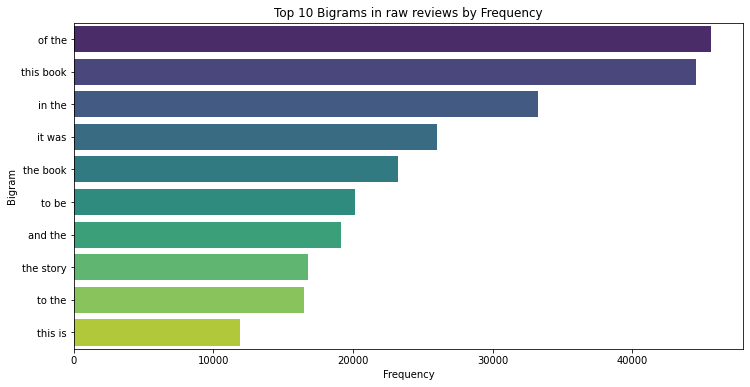

In [47]:
top_words_dict_uncleaned = dict(top_words_uncleaned)
top_bigrams_dict_uncleaned = dict(top_bigrams_uncleaned)

# Convert to DataFrame for easier plotting
top_words_df_uncleaned = pd.DataFrame(list(top_words_dict_uncleaned.items()), columns=['Word', 'Frequency'])
top_bigrams_df_uncleaned = pd.DataFrame(list(top_bigrams_dict_uncleaned.items()), columns=['Bigram', 'Frequency'])

# Sort the DataFrames by frequency in descending order
top_words_df_uncleaned = top_words_df_uncleaned.sort_values(by='Frequency', ascending=False)
top_bigrams_df_uncleaned = top_bigrams_df_uncleaned.sort_values(by='Frequency', ascending=False)

# Plot the top words
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=top_words_df_uncleaned, palette='viridis')
plt.title('Top 10 Words in raw reviews by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Plot the top bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df_uncleaned, palette='viridis')
plt.title('Top 10 Bigrams in raw reviews by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()

#### We can see the words are not relevant, they are 'stop' words, after cleaning let's see what the results are

In [48]:
top_words = get_top_n_words(sampled_reviews['cleaned_text'], n=10)
top_bigrams = get_top_n_grams(sampled_reviews['cleaned_text'], n=10, ngram=2)

Processing N-grams: 100%|████████████████████████████████████████████████| 1841095/1841095 [00:02<00:00, 897196.94it/s]


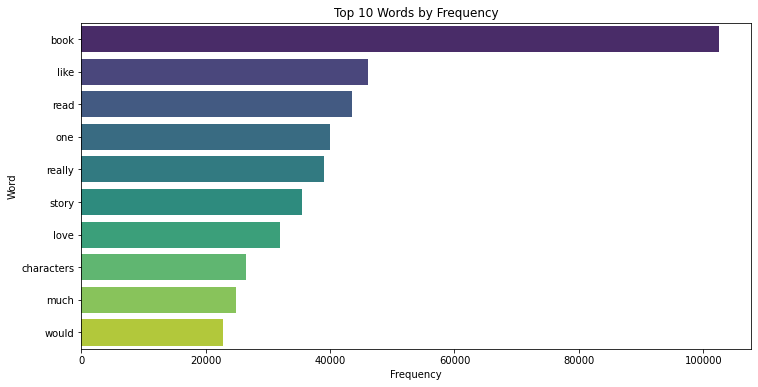

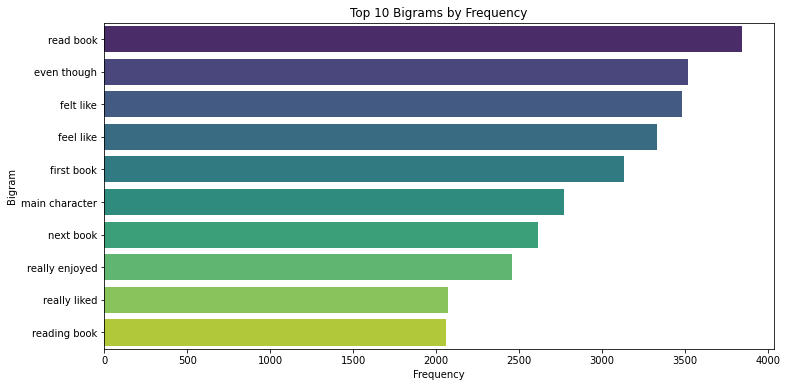

In [42]:
top_words_dict = dict(top_words)
top_bigrams_dict = dict(top_bigrams)

# Convert to DataFrame for easier plotting
top_words_df = pd.DataFrame(list(top_words_dict.items()), columns=['Word', 'Frequency'])
top_bigrams_df = pd.DataFrame(list(top_bigrams_dict.items()), columns=['Bigram', 'Frequency'])

# Sort the DataFrames by frequency in descending order
top_words_df = top_words_df.sort_values(by='Frequency', ascending=False)
top_bigrams_df = top_bigrams_df.sort_values(by='Frequency', ascending=False)

# Plot the top words
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=top_words_df, palette='viridis')
plt.title('Top 10 Words by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Plot the top bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, palette='viridis')
plt.title('Top 10 Bigrams by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()

#### We can see the words are much better, the cleaning was effective

Processing N-grams: 100%|████████████████████████████████████████████████| 1841095/1841095 [00:02<00:00, 917552.76it/s]


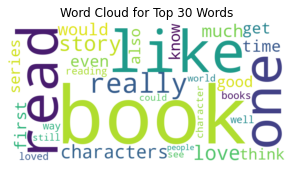

In [51]:
# Word cloud
top_words = get_top_n_words(sampled_reviews['cleaned_text'], n=30)
top_bigrams = get_top_n_grams(sampled_reviews['cleaned_text'], n=30, ngram=2)
top_words_dict = dict(top_words)
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(top_words_dict)

plt.figure(figsize=(5, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Top 30 Words')
plt.show()

## Sentiment analysis

### Loading distilBert

In [68]:
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased')

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

C:\Users\timot\anaconda3\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\timot\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#### Concatenating the review words to 512 characters

In [73]:
def concatenate_and_limit(text_list):
    text = ' '.join(text_list)
    return text[:512]

# Apply the function to the 'cleaned_text' column to create a new column
sampled_reviews['limited_text'] = sampled_reviews['cleaned_text'].apply(concatenate_and_limit)

In [247]:
sampled_reviews.head(1)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,...,cleaned_text,cleaned_text_str,limited_text,classification_result,review_sentiment,contains_label_1,sentiment_category,test_sentiment,sentiment_category_2,ground_truth
0,4a2be6395f9a7826b132065a47ca019e,5,ca23d9615ed0865e8e7ba98b311fc42c,3,I believe this is the book where Harry suddenl...,Fri Jan 09 10:28:42 -0800 2009,Fri Jan 09 10:30:07 -0800 2009,Wed Sep 15 00:00:00 -0700 1999,NaN,0,...,"['believ', 'book', 'harri', 'suddenli', 'devel...",believ book harri suddenli develop temper thin...,believ book harri suddenli develop temper thin...,"[{'label': 'LABEL_0', 'score': 0.5270383358001...",0.0,False,Neutral,0.0,Neutral,Negative


#### Applying BERT classifier on the reviews to get sentiment analysis on the reviews

In [74]:
# Initialize tqdm for progress tracking
tqdm.pandas()

# Classify the text in the limited_text column
sampled_reviews['classification_result'] = sampled_reviews['limited_text'].progress_apply(classifier)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [2:10:16<00:00,  6.40it/s]


In [94]:
for i in range(10):
    print(sampled_reviews['classification_result'].iloc[i])

3 [{'label': 'LABEL_0', 'score': 0.5270383358001709}]


In [128]:
# Function to check if 'LABEL_1' is in the classification_result
def contains_label_1(result_list):
    for result in result_list:
        if result['label'] == 'LABEL_1':
            return True
    return False

# Apply the function to each row to check if it contains 'LABEL_1'
sampled_reviews['contains_label_1'] = sampled_reviews['classification_result'].apply(contains_label_1)

# Count the occurrences of 'LABEL_0' (negative) and 'LABEL_1' (positive)
count_label_0 = sampled_reviews['contains_label_1'].eq(False).sum()
count_label_1 = sampled_reviews['contains_label_1'].sum()

# Display the count next to the translated prediction
print(f"Negative (LABEL_0): {count_label_0}")
print(f"Positive (LABEL_1): {count_label_1}")

Negative (LABEL_0): 49977
Positive (LABEL_1): 23


It looks like distillbert struggled with sentiment analysis on the dataframe. Almost all predictions indicate negative reviews, which is strange, let's try another way.

### Sentiment Analysis using TextBlob

Basic model, not trained on the specific data : 

In [111]:
def calculate_sentiment(text):
    analysis = TextBlob(" ".join(text))  # Join the words in the list into a single sentence
    return analysis.sentiment.polarity

# Calculate sentiment for each review and store in a new column
sampled_reviews['review_sentiment'] = sampled_reviews['cleaned_text'].progress_apply(lambda x: calculate_sentiment(x))

Cleaning and Correcting Text: 100%|████████████████████████████████████████████| 50000/50000 [00:17<00:00, 2867.74it/s]


In [138]:
# We will consider that pure 0 is a neutral sentiment review, negative is negative and positive positive
def categorize_sentiment(sentiment):
    if sentiment < 0:
        return 'Negative'
    elif sentiment > 0:
        return 'Positive'
    else:
        return 'Neutral'

In [137]:
# Apply the sentiment categorization function
sampled_reviews['sentiment_category'] = sampled_reviews['review_sentiment'].apply(categorize_sentiment)

# Count the occurrences of sentiment categories
count_negative = (sampled_reviews['sentiment_category'] == 'Negative').sum()
count_neutral = (sampled_reviews['sentiment_category'] == 'Neutral').sum()
count_positive = (sampled_reviews['sentiment_category'] == 'Positive').sum()

print(f"Negative (Sentiment): {count_negative}")
print(f"Neutral (Sentiment): {count_neutral}")
print(f"Positive (Sentiment): {count_positive}")

Negative (Sentiment): 7176
Neutral (Sentiment): 5385
Positive (Sentiment): 37439


#### As we can see 75% of reviews are positive, 15% are negative and the remaining 10% are neutral

#### This output is quite logical it seems, since we selected the top 1000 best books with more than 50 reviews by average ratings

#### Evaluation of the model : 

We will consider that : <br>
0   <= AVERAGE RATING <= 3   :  NEGATIVE  <br> 
3   <  AVERAGE RATING < 4    :  NEUTRAL <br>
4   <= AVERAGE RATING <= 5 :  POSITIVE <br>

In [142]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the ground truth labels based on average rating
sampled_reviews['ground_truth'] = sampled_reviews['rating'].apply(lambda x: 'Negative' if x <= 3 else ('Neutral' if x < 4 else 'Positive'))

# Calculate accuracy
accuracy = accuracy_score(sampled_reviews['ground_truth'], sampled_reviews['sentiment_category'])

# Calculate precision, recall, and F1-score for each category
precision_negative = precision_score(sampled_reviews['ground_truth'], sampled_reviews['sentiment_category'], average='weighted', labels=['Negative'])
precision_neutral = precision_score(sampled_reviews['ground_truth'], sampled_reviews['sentiment_category'], average='weighted', labels=['Neutral'])
precision_positive = precision_score(sampled_reviews['ground_truth'], sampled_reviews['sentiment_category'], average='weighted', labels=['Positive'])

recall_negative = recall_score(sampled_reviews['ground_truth'], sampled_reviews['sentiment_category'], average='weighted', labels=['Negative'])
recall_neutral = recall_score(sampled_reviews['ground_truth'], sampled_reviews['sentiment_category'], average='weighted', labels=['Neutral'])
recall_positive = recall_score(sampled_reviews['ground_truth'], sampled_reviews['sentiment_category'], average='weighted', labels=['Positive'])

f1_negative = f1_score(sampled_reviews['ground_truth'], sampled_reviews['sentiment_category'], average='weighted', labels=['Negative'])
f1_neutral = f1_score(sampled_reviews['ground_truth'], sampled_reviews['sentiment_category'], average='weighted', labels=['Neutral'])
f1_positive = f1_score(sampled_reviews['ground_truth'], sampled_reviews['sentiment_category'], average='weighted', labels=['Positive'])

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision (Negative): {precision_negative}")
print(f"Precision (Neutral): {precision_neutral}")
print(f"Precision (Positive): {precision_positive}")
print(f"Recall (Negative): {recall_negative}")
print(f"Recall (Neutral): {recall_neutral}")
print(f"Recall (Positive): {recall_positive}")
print(f"F1-score (Negative): {f1_negative}")
print(f"F1-score (Neutral): {f1_neutral}")
print(f"F1-score (Positive): {f1_positive}")

C:\Users\timot\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.59232
Precision (Negative): 0.47408026755852845
Precision (Neutral): 0.0
Precision (Positive): 0.700178957771308
Recall (Negative): 0.20507565254084031
Recall (Neutral): 0.0
Recall (Positive): 0.7845919008709706
F1-score (Negative): 0.2863033873343152
F1-score (Neutral): 0.0
F1-score (Positive): 0.7399858856739591


### Let's face it, untrained model can't realluy predict the sentiment well. Let's try with a trained BERT : 

In [150]:
file_path = 'D:/s9/NLP/projet3/goodreads_reviews/sampled_reviews.csv'

# Save the DataFrame to a CSV file
sampled_reviews.to_csv(file_path, index=False)

In [3]:
sampled_reviews = pd.read_csv("D:/s9/NLP/projet3/goodreads_reviews/sampled_reviews.csv")

In [7]:
# For TensorFlow
from tensorflow.summary import create_file_writer

# For PyTorch
from torch.utils.tensorboard import SummaryWriter

### We tried to implement a BERT pre-trained model fine tune it on our dataset (even following its progress on tensorboard), but it could never run, exceding the RAM of our computers and google collab's one

In [ ]:
# from transformers import BertTokenizer, BertForSequenceClassification
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Split your data into train and validation sets
# train_data, val_data = train_test_split(sampled_reviews, test_size=0.2, random_state=42)

# # Initialize BERT tokenizer and model
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # 3 labels for Negative, Neutral, Positive

# # Tokenize and encode the text data
# train_tokens = tokenizer(list(train_data['cleaned_text']), padding=True, truncation=True, return_tensors='pt')
# val_tokens = tokenizer(list(val_data['cleaned_text']), padding=True, truncation=True, return_tensors='pt')

# # Define a mapping for the labels
# label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

# # Function to convert labels to integers
# def convert_labels_to_int(labels, mapping):
#     return [mapping[label] for label in labels]

# # Convert ground_truth labels in train and validation data
# train_labels = convert_labels_to_int(train_data['ground_truth'], label_mapping)
# val_labels = convert_labels_to_int(val_data['ground_truth'], label_mapping)

# train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(train_labels))
# val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(val_labels))

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # Define optimizer and loss function
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# criterion = torch.nn.CrossEntropyLoss()

# # Training loop
# epochs = 10
# model.train()
# for epoch in range(epochs):
#     train_loss = 0
#     correct = 0
#     total = 0
#     train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False)

#     for batch in train_loader_tqdm:
#         inputs, masks, labels = batch
#         optimizer.zero_grad()
#         outputs = model(inputs, attention_mask=masks, labels=labels)
#         loss = outputs.loss
#         train_loss += loss.item()
#         loss.backward()
#         optimizer.step()

#         # Calculate accuracy
#         _, predicted = torch.max(outputs.logits, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         # Update tqdm progress bar with loss
#         train_loader_tqdm.set_postfix(loss=loss.item())

#     # Calculate average loss and accuracy
#     train_loss /= len(train_loader)
#     train_accuracy = 100 * correct / total

#     # Log to TensorBoard
#     writer.add_scalar('Loss/train', train_loss, epoch)
#     writer.add_scalar('Accuracy/train', train_accuracy, epoch)

# # Evaluation
# model.eval()
# val_predictions = []
# val_true_labels = []
# val_loss = 0
# val_loader_tqdm = tqdm(val_loader, desc='Validation', leave=False)

# with torch.no_grad():
#     for batch in val_loader_tqdm:
#         inputs, masks, labels = batch
#         outputs = model(inputs, attention_mask=masks)
#         logits = outputs.logits
#         loss = criterion(logits, labels)
#         val_loss += loss.item()
#         predicted_labels = torch.argmax(logits, dim=1)
#         val_predictions.extend(predicted_labels.tolist())
#         val_true_labels.extend(labels.tolist())

# # Calculate validation loss and accuracy
# val_loss /= len(val_loader)
# val_accuracy = accuracy_score(val_true_labels, val_predictions)

# # Log to TensorBoard
# writer.add_scalar('Loss/validation', val_loss, epoch)
# writer.add_scalar('Accuracy/validation', val_accuracy, epoch)

# # Additional metrics
# classification_rep = classification_report(val_true_labels, val_predictions, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)
# conf_matrix = confusion_matrix(val_true_labels, val_predictions)

# # Convert confusion matrix to image tensor
# cm_image = plot_confusion_matrix(conf_matrix, ['Negative', 'Neutral', 'Positive'])

# # Log to TensorBoard
# writer.add_scalar('Metrics/Accuracy', val_accuracy)
# for label, metrics in classification_rep.items():
#     if isinstance(metrics, dict):
#         writer.add_scalars(f'Metrics/Classification_Report/{label}', metrics, epoch)
# writer.add_image('Metrics/Confusion_Matrix', cm_image, epoch)

# # Close tqdm progress bar for validation
# val_loader_tqdm.close()

# # Close TensorBoard writer
# writer.close()

### Instead we will implement classical random forest models, then XGboost

In [251]:
sampled_reviews['review_clean'] = sampled_reviews['review_text'].progress_apply(clean_text)

Cleaning and Correcting summaries: 100%|███████████████████████████████████████| 50000/50000 [00:06<00:00, 7407.21it/s]


In [340]:
def assign_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    return 'positive'

sampled_reviews['sentiment'] = sampled_reviews['rating'].apply(assign_sentiment)

In [341]:
X = sampled_reviews['review_clean']
y = sampled_reviews['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [342]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [353]:
#joblib.dump(vectorizer, 'D:/s9/NLP/github_projectapp_repo/NLP_project_app/tfidf_vectorizer.joblib')

['D:/s9/NLP/github_projectapp_repo/NLP_project_app/tfidf_vectorizer.joblib']

In [255]:
class TqdmParallel(Parallel):
    def __call__(self, *args, **kwargs):
        with tqdm(total=kwargs.pop('total', self.n_jobs)) as self._tqdm:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._tqdm.total == self.n_dispatched_tasks:
            self._tqdm.update(n=self.n_completed_tasks - self._tqdm.n)
        else:
            self._tqdm.total = self.n_dispatched_tasks
            self._tqdm.update(n=self.n_completed_tasks - self._tqdm.n)

# Train the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

with parallel_backend('loky', n_jobs=-1):
    rf_classifier.fit(X_train_tfidf, y_train)

In [256]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = rf_classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.87      0.26      0.41      1364
     neutral       0.89      0.20      0.32      1975
    positive       0.72      0.99      0.84      6661

    accuracy                           0.74     10000
   macro avg       0.83      0.48      0.52     10000
weighted avg       0.77      0.74      0.68     10000

Accuracy: 0.7362


### This basic model is not bad, let's try to find optimal hyper-parameters :

In [257]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [258]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train_tfidf, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [259]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [354]:
optimized_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

optimized_rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(min_samples_split=5, n_jobs=-1, random_state=42)

In [355]:
optimized_predictions = optimized_rf.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, optimized_predictions))
print("Accuracy:", accuracy_score(y_test, optimized_predictions))

              precision    recall  f1-score   support

    negative       0.87      0.27      0.41      1364
     neutral       0.86      0.19      0.31      1975
    positive       0.72      0.99      0.84      6661

    accuracy                           0.74     10000
   macro avg       0.82      0.48      0.52     10000
weighted avg       0.77      0.74      0.68     10000

Accuracy: 0.7363


### Saving the model

In [357]:
# Save the model to a file
#joblib.dump(optimized_rf, 'D:/s9/NLP/github_projectapp_repo/NLP_project_app/optimized_rf_model.joblib')
#joblib.dump(new_tfidf_vectorizer, 'D:/s9/NLP/project2_app/NLP_project2_app/QA_tfidf_vectorizer.joblib')

['D:/s9/NLP/github_projectapp_repo/NLP_project_app/optimized_rf_model.joblib']

Testing with input sentences/reviews

In [284]:
def predict_sentiment(review, model, vectorizer, label_encoder):
    # Preprocess the input the same way the training data was
    review = clean_text(review)
    review_vectorized = vectorizer.transform([review])

    # Make a prediction
    prediction_label = model.predict(review_vectorized)[0]
    prediction_proba = model.predict_proba(review_vectorized)[0]

    # Map the predicted label to its index
    prediction_index = label_encoder.transform([prediction_label])[0]

    # Get the probability of the predicted class
    score = prediction_proba[prediction_index]

    return prediction_label, score

In [310]:
# Loading the model
#optimized_rf = joblib.load('optimized_rf_model.joblib')

In [351]:
review_text = "bad book"
label_encoder = LabelEncoder().fit(['negative', 'neutral', 'positive'])  # Fit with all possible labels
sentiment, score = predict_sentiment(review_text, optimized_rf, vectorizer, label_encoder)
print(f"Sentiment: {sentiment}, Score: {score}")

Sentiment: negative, Score: 0.4436507936507937


### Let's try to fit another model for the same sentiment analysis task :

### Xgboost for sentiment analysis

In [265]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [268]:
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train_encoded)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test_encoded)

In [269]:
params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'multi:softprob',
    'num_class': 3
}

In [270]:
num_boost_round = 999

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mlogloss:0.97519
[1]	Test-mlogloss:0.90234
[2]	Test-mlogloss:0.85680
[3]	Test-mlogloss:0.82718
[4]	Test-mlogloss:0.80678
[5]	Test-mlogloss:0.79182
[6]	Test-mlogloss:0.78048
[7]	Test-mlogloss:0.77072
[8]	Test-mlogloss:0.76289
[9]	Test-mlogloss:0.75651
[10]	Test-mlogloss:0.75126
[11]	Test-mlogloss:0.74708
[12]	Test-mlogloss:0.74224
[13]	Test-mlogloss:0.73833
[14]	Test-mlogloss:0.73497
[15]	Test-mlogloss:0.73128
[16]	Test-mlogloss:0.72836
[17]	Test-mlogloss:0.72547
[18]	Test-mlogloss:0.72294
[19]	Test-mlogloss:0.72008
[20]	Test-mlogloss:0.71738
[21]	Test-mlogloss:0.71519
[22]	Test-mlogloss:0.71299
[23]	Test-mlogloss:0.71150
[24]	Test-mlogloss:0.70954
[25]	Test-mlogloss:0.70717
[26]	Test-mlogloss:0.70512
[27]	Test-mlogloss:0.70290
[28]	Test-mlogloss:0.70135
[29]	Test-mlogloss:0.69950
[30]	Test-mlogloss:0.69765
[31]	Test-mlogloss:0.69602
[32]	Test-mlogloss:0.69420
[33]	Test-mlogloss:0.69275
[34]	Test-mlogloss:0.69129
[35]	Test-mlogloss:0.68997
[36]	Test-mlogloss:0.68816
[37]	Test-m

[297]	Test-mlogloss:0.61178
[298]	Test-mlogloss:0.61174
[299]	Test-mlogloss:0.61164
[300]	Test-mlogloss:0.61163
[301]	Test-mlogloss:0.61178
[302]	Test-mlogloss:0.61174
[303]	Test-mlogloss:0.61155
[304]	Test-mlogloss:0.61150
[305]	Test-mlogloss:0.61133
[306]	Test-mlogloss:0.61122
[307]	Test-mlogloss:0.61120
[308]	Test-mlogloss:0.61115
[309]	Test-mlogloss:0.61107
[310]	Test-mlogloss:0.61099
[311]	Test-mlogloss:0.61100
[312]	Test-mlogloss:0.61097
[313]	Test-mlogloss:0.61095
[314]	Test-mlogloss:0.61096
[315]	Test-mlogloss:0.61095
[316]	Test-mlogloss:0.61085
[317]	Test-mlogloss:0.61085
[318]	Test-mlogloss:0.61075
[319]	Test-mlogloss:0.61070
[320]	Test-mlogloss:0.61070
[321]	Test-mlogloss:0.61069
[322]	Test-mlogloss:0.61056
[323]	Test-mlogloss:0.61054
[324]	Test-mlogloss:0.61041
[325]	Test-mlogloss:0.61016
[326]	Test-mlogloss:0.61012
[327]	Test-mlogloss:0.61021
[328]	Test-mlogloss:0.61014
[329]	Test-mlogloss:0.61009
[330]	Test-mlogloss:0.61011
[331]	Test-mlogloss:0.61003
[332]	Test-mlogloss:

In [271]:
# Make predictions
preds = bst.predict(dtest)
predictions = preds.argmax(axis=1)

# Decode the predictions
decoded_predictions = label_encoder.inverse_transform(predictions)

# Evaluate the model
print(classification_report(y_test, decoded_predictions))
print("Accuracy:", accuracy_score(y_test, decoded_predictions))

              precision    recall  f1-score   support

    negative       0.70      0.43      0.53      1364
     neutral       0.57      0.34      0.43      1975
    positive       0.79      0.94      0.86      6661

    accuracy                           0.75     10000
   macro avg       0.69      0.57      0.61     10000
weighted avg       0.73      0.75      0.73     10000

Accuracy: 0.7549


In [303]:
param_grid = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [308]:
# Save the model to a file
bst.save_model('D:/s9/NLP/project2_app/NLP_project2_app/xgboost_model.json')

In [309]:
#loaded_bst = xgb.Booster()
#loaded_bst.load_model('xgboost_model.json')

In [ ]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

We tried to fit an optimal xgboost but it took too much time

#### The model performs slightly better than random forest but still struggles to predict negative and neutral classes

### We can identify here a clear limit of both our model : 
### The training data has a vast majority of positive reviews, so the models struggle with negative reviews

## Homogenization of training data reviews ratings

ratings are integers from 0 to 5 (inclusive), we select 10 000 reviews of each rating

In [361]:
sub_df = df.groupby('rating').apply(lambda x: x.sample(n=10000)).reset_index(drop=True)
# sub_df now contains 10000 reviews for each rating

In [443]:
sub_df.shape

(60000, 14)

In [444]:
rating_counts = sub_df['rating'].value_counts()
rating_percentages = sub_df['rating'].value_counts(normalize=True) * 100  # Convert to percentage

# Combine counts and percentages into a single DataFrame
rating_summary = pd.DataFrame({'Count': rating_counts, 'Percentage': rating_percentages})

print(rating_summary)

   Count  Percentage
0  10000   16.666667
1  10000   16.666667
2  10000   16.666667
3  10000   16.666667
4  10000   16.666667
5  10000   16.666667


### Repeating all the steps, preprocessing the reviews, associating rating to a sentiment for classification

In [363]:
sub_df['review_clean'] = sub_df['review_text'].progress_apply(clean_text)

Cleaning and Correcting summaries: 100%|███████████████████████████████████████| 60000/60000 [00:07<00:00, 8488.50it/s]


In [364]:
sub_df['sentiment'] = sub_df['rating'].apply(assign_sentiment)

#### Fitting an optimal random forest model for classification

In [445]:
X = sub_df['review_clean']
y = sub_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [366]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [367]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [368]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


In [369]:
optimized_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

optimized_rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(min_samples_split=5, n_jobs=-1, random_state=42)

In [446]:
y_pred = optimized_rf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.66      0.89      0.76      5909
     neutral       0.45      0.01      0.03      2068
    positive       0.66      0.67      0.67      4023

    accuracy                           0.66     12000
   macro avg       0.59      0.52      0.48     12000
weighted avg       0.63      0.66      0.60     12000

Accuracy: 0.6630833333333334


### We could think 0.66 is worse than 0.75 (previous model accuracy), but the score before was biased by the positive accuracy being enormous. Here, in comparison, we have much better f1 scores and recall and the prediction for negatives are much higher. The model still struggles with neutral reviews, but overall, the model has improved !

In [442]:
#joblib.dump(optimized_rf, 'D:/s9/NLP/NLP_repository/balanced_optimized_rf_model.joblib')
#joblib.dump(vectorizer, 'D:/s9/NLP/NLP_repository/balanced_tfidf_vectorizer.joblib')

['D:/s9/NLP/NLP_repository/balanced_tfidf_vectorizer.joblib']

#### trying to predict review rating in addition to sentiment

In [422]:
X = sub_df['review_clean']
y_rating = sub_df['rating']
    
X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(X, y_rating, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_rating_tfidf = vectorizer.fit_transform(X_train_rating)
X_test_rating_tfidf = vectorizer.transform(X_test_rating)

In [428]:
sub_df['review_clean'].head(1)

0    read half enjoying skipped read last chapter k...
Name: review_clean, dtype: object

In [424]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_rating_tfidf, y_train_rating)

RandomForestRegressor(random_state=42)

In [425]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred_rating = regressor.predict(X_test_rating_tfidf)

mse = mean_squared_error(y_test_rating, y_pred_rating)
mae = mean_absolute_error(y_test_rating, y_pred_rating)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 2.063096038933473
Mean Absolute Error: 1.1104914496409541


In [448]:
y_pred_rounded = np.round(y_pred_rating)

# Calculate accuracy
accuracy = accuracy_score(y_test_rating, y_pred_rounded)
print(f"Accuracy (Exact Match): {accuracy * 100:.2f}%")

# You already have MSE and MAE calculated
mse = mean_squared_error(y_test_rating, y_pred_rating)
mae = mean_absolute_error(y_test_rating, y_pred_rating)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Accuracy (Exact Match): 29.85%
Mean Squared Error: 2.06
Mean Absolute Error: 1.11


#### Not great, the problem is that the correlation between the review and the rating is sometimes not exact, since some users will write a negative comment but rate the book a 3, or sometimes they will talk about negative stuff for 4 lines and still say its a great book. We could try to ameliorate the model with more reviews, or a more exact classification

## Grouping the data by book and scraping aditionnal information

In [449]:
# Function to scrap a book's name and summary by its book_id contained in the original dataset
def get_book_name_and_summary(book_id):
    url = f'https://www.goodreads.com/book/show/{book_id}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the element containing the book's name
    title_element = soup.find('h1', {'class': 'Text Text__title1', 'data-testid': 'bookTitle'})
    if not title_element:
        return 'Title not found', None

    book_name = title_element.text.strip()

    # Find the element containing the book's summary
    summary_element = soup.find('span', {'class': 'Formatted'})
    if summary_element:
        return book_name, summary_element
    else:
        return book_name, 'Summary not found'

The rating becomes the average rating for the 50 reviews, the sentiment is the sum of the sentiments of the 50 reviews, we also add the summary and get the book name for that book_id. The data is scraped on Goodreads : https://www.goodreads.com/

In [23]:
# Initialize tqdm for progress tracking
tqdm.pandas()

# Group by book_id
grouped_reviews = sampled_reviews.groupby('book_id')

# Calculate average_rating for each group
average_rating = grouped_reviews['rating'].mean()

# Calculate review_sentiment as the sum of predicted sentiment scores
review_sentiment = grouped_reviews['review_sentiment'].sum()

# Get book names and summaries using the provided function with tqdm
book_info = grouped_reviews.progress_apply(lambda x: get_book_name_and_summary(x['book_id'].iloc[0]))

# Create a DataFrame with the results
book_df = pd.DataFrame({
    'book_name': book_info.apply(lambda x: x[0]),
    'book_summary': book_info.apply(lambda x: x[1]),
    'average_rating': average_rating,
    'review_sentiment': review_sentiment
})

# Rename the columns and set the book_name as the index
book_df = book_df.rename(columns={'book_id': 'book_name'})

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [40:15<00:00,  2.42s/it]


In [33]:
missing_summary_count = book_df['book_summary'].isna().sum()
print(f"Number of missing summaries: {missing_summary_count}")

Number of missing summaries: 3


We will drop books with no summary

In [38]:
book_df = book_df.dropna(subset=['book_summary'])

In [39]:
book_df.shape

(997, 4)

Saving the dataframe

In [55]:
#file_path = 'D:/s9/NLP/projet3/goodreads_reviews/1000_best_books_summary.csv'

# Save the DataFrame to a CSV file
#book_df.to_csv(file_path, index=False)

In [124]:
book_df = pd.read_csv("D:/s9/NLP/projet3/goodreads_reviews/1000_best_books_summary.csv")

In [29]:
book_df['book_summary'].iloc[0]

<span class="Formatted">It is the middle of the summer, but there is an unseasonal mist pressing against the windowpanes. Harry Potter is waiting nervously in his bedroom at the Dursleys' house in Privet Drive for a visit from Professor Dumbledore himself. One of the last times he saw the Headmaster, he was in a fierce one-to-one duel with Lord Voldemort, and Harry can't quite believe that Professor Dumbledore will actually appear at the Dursleys' of all places. Why is the Professor coming to visit him now? What is it that cannot wait until Harry returns to Hogwarts in a few weeks' time? Harry's sixth year at Hogwarts has already got off to an unusual start, as the worlds of Muggle and magic start to intertwine...</span>

The scraped summaries are still messy, let's remove the html tags :

In [43]:
def clean_summary(summary):
    # Parse the HTML using BeautifulSoup
    soup = BeautifulSoup(summary, 'html.parser')
    
    # Extract the text content without HTML tags
    cleaned_text = soup.get_text()
    
    # Remove extra whitespaces and newline characters
    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text

# Apply the clean_summary function to the 'book_summary' column
book_df['cleaned_summary'] = book_df['book_summary'].apply(clean_summary)

In [126]:
book_df['cleaned_summary'].iloc[0]

"It is the middle of the summer, but there is an unseasonal mist pressing against the windowpanes. Harry Potter is waiting nervously in his bedroom at the Dursleys' house in Privet Drive for a visit from Professor Dumbledore himself. One of the last times he saw the Headmaster, he was in a fierce one-to-one duel with Lord Voldemort, and Harry can't quite believe that Professor Dumbledore will actually appear at the Dursleys' of all places. Why is the Professor coming to visit him now? What is it that cannot wait until Harry returns to Hogwarts in a few weeks' time? Harry's sixth year at Hogwarts has already got off to an unusual start, as the worlds of Muggle and magic start to intertwine..."

Looks good !

In [48]:
book_df = book_df.drop('book_summary', axis=1)

In [127]:
book_df.head(1)

,book_name,average_rating,review_sentiment,cleaned_summary
0,Harry Potter and the Half-Blood Prince,4.58,9.368922,"It is the middle of the summer, but there is a..."


## Word2Vec to identify similar words

#### Preprocessing for word2vec model on the top 1000 book summaries

In [411]:
book_df['book_summary_cleaned_pour_de_vrai'] = book_df['cleaned_summary'].progress_apply(clean_text)

Cleaning and Correcting summaries: 100%|██████████████████████████████████████████| 997/997 [00:00<00:00, 11329.45it/s]


In [412]:
print(book_df['book_summary_cleaned_pour_de_vrai'])

0      middle summer unseasonal mist pressing windowp...
1      harry potter start fifth year hogwarts school ...
2      harry potter idea famous raised miserable aunt...
3      harry potter along best friends ron hermione s...
4      summer holidays soon harry potter starting fou...
                             ...                        
992    kate harker afraid monsters hunts good august ...
993    alternate cover edition isbn found sixteen yea...
994    alternate cover edition asin b j u one us lyin...
995    probably found way page follow reviews goodrea...
996    lara jean best senior year still much look for...
Name: book_summary_cleaned_pour_de_vrai, Length: 997, dtype: object


In [413]:
# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=book_df['book_summary_cleaned_pour_de_vrai'], vector_size=100, window=5, min_count=1, workers=4)

In [405]:
# Saving
#word2vec_model.save("D:/s9/NLP/fresh_repo/word2vec_model.model")

### Displaying the word embeddings in 2 dimensions with TNSE and K-means for clustering

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19430 samples in 0.000s...
[t-SNE] Computed neighbors for 19430 samples in 11.803s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19430
[t-SNE] Computed conditional probabilities for sample 2000 / 19430
[t-SNE] Computed conditional probabilities for sample 3000 / 19430
[t-SNE] Computed conditional probabilities for sample 4000 / 19430
[t-SNE] Computed conditional probabilities for sample 5000 / 19430
[t-SNE] Computed conditional probabilities for sample 6000 / 19430
[t-SNE] Computed conditional probabilities for sample 7000 / 19430
[t-SNE] Computed conditional probabilities for sample 8000 / 19430
[t-SNE] Computed conditional probabilities for sample 9000 / 19430
[t-SNE] Computed conditional probabilities for sample 10000 / 19430
[t-SNE] Computed conditional probabilities for sample 11000 / 19430
[t-SNE] Computed conditional probabilities for sample 12000 / 19430
[t-SNE] Computed conditional probabilities for sa

C:\Users\timot\AppData\Local\Temp/ipykernel_15668/109073718.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_clusters)


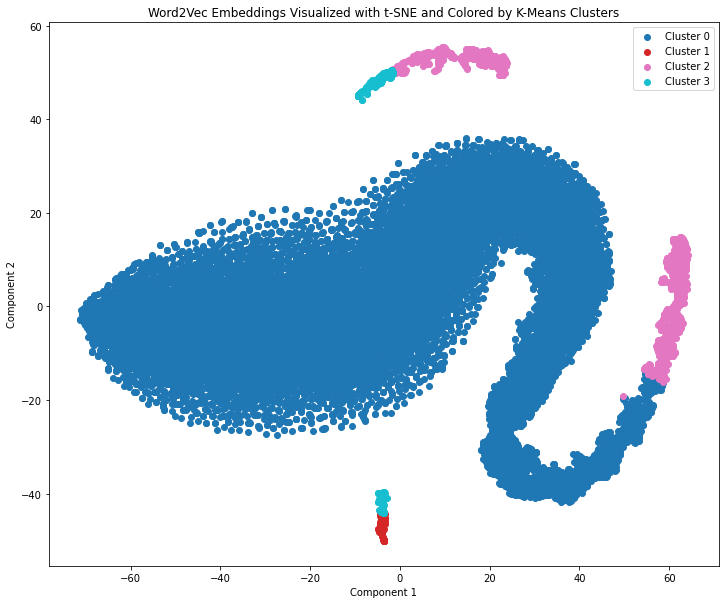

In [318]:
words = np.random.choice(list(word2vec_model.wv.index_to_key), len(list(word2vec_model.wv.index_to_key)), replace=False)  # Sample 300 words
word_vectors = np.array([word2vec_model.wv[word] for word in words])

# Perform K-Means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(word_vectors)
cluster_labels = kmeans.labels_

# Set up t-SNE
tsne = TSNE(n_components=2, verbose=1, random_state=23)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Create a scatter plot of the t-SNE reduced word vectors, colored by cluster assignment
plt.figure(figsize=(12, 10))

# Generate a color map for the clusters
colors = plt.cm.get_cmap('tab10', num_clusters)

for i in range(num_clusters):
    # Select only data points that belong to the current cluster
    indices = [index for index, label in enumerate(cluster_labels) if label == i]
    current_cluster_vectors_2d = word_vectors_2d[indices]

    # Scatter plot for each cluster
    plt.scatter(current_cluster_vectors_2d[:, 0], current_cluster_vectors_2d[:, 1], c=[colors(i)], label=f'Cluster {i}')

plt.title('Word2Vec Embeddings Visualized with t-SNE and Colored by K-Means Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend() 
plt.show()


Saving and loading models if need later

In [322]:
#joblib.dump(kmeans, 'D:/s9/NLP/project2_app/NLP_project2_app/kmeans_model.joblib')

['D:/s9/NLP/project2_app/NLP_project2_app/kmeans_model.joblib']

In [323]:
#joblib.dump(word_vectors_2d, 'D:/s9/NLP/project2_app/NLP_project2_app/tsne_transformed_data.joblib')

['D:/s9/NLP/project2_app/NLP_project2_app/tsne_transformed_data.joblib']

In [325]:
# Load Word2Vec Model
#loaded_word2vec_model = Word2Vec.load("word2vec_model.model")

# Load KMeans Model
#loaded_kmeans = joblib.load('kmeans_model.joblib')

# Load t-SNE Transformed Data
#loaded_word_vectors_2d = joblib.load('tsne_transformed_data.joblib')

#### Trying to put labels on the clusters

In [320]:
# Mapping words to their cluster labels
word_cluster_mapping = {word: cluster_labels[i] for i, word in enumerate(words)}

In [455]:
for i in range(num_clusters):
    print(f"\nWords in Cluster {i}:")
    cluster_words = [word for word, cluster in word_cluster_mapping.items() if cluster == i]
    
    sample_words = cluster_words[40:60] if len(cluster_words) > 20 else cluster_words
    print(", ".join(sample_words))


Words in Cluster 0:
Golds—and, crooked-smiling, outburst, wish, targets.Lada, Vega, Declan, Christy, fun.But, way…, another.From, Adeline, Bascom—or, Annabel, years.Using, charmed, 9,000, crude, Hillis, mud

Words in Cluster 1:
an, them, will, for, even, one, out, on, her, New, to, she, from, been, just, its, with, into, by, a

Words in Cluster 2:
quest, Little, surprising, thrilling, especially, gets, public, haunting, award-winning, sixteen-year-old, intense, England, siblings, competition, Clara, sex, tales, mind, training, quiet

Words in Cluster 3:
For, deadly, best, time, other, go, people, takes, What, tale, future, true, come, being, against, All, man, over, 're, left


#### There doesn't seem to be a direct ling between the words in the clusters...

### Using Cosine similarity to do semantic search based on that trained model

In [132]:
def semantic_search(model, search_term, top_n=5):
    search_term_vector = model.wv[search_term]
    similarities = []
    for word in model.wv.index_to_key:
        if word == search_term:
            continue
        word_vector = model.wv[word]
        sim = cosine_similarity([search_term_vector], [word_vector])
        similarities.append((word, sim[0][0]))

    return sorted(similarities, key=lambda item: -item[1])[:top_n]

In [459]:
semantic_search(word2vec_model, 'magic', top_n=10)

[('life', 0.99993634),
 ('world', 0.99993455),
 ('one', 0.99993265),
 ('like', 0.9999214),
 ('even', 0.9999207),
 ('must', 0.999918),
 ('time', 0.9999178),
 ('night', 0.99991757),
 ('ever', 0.9999166),
 ('way', 0.99991614)]

### The result isn't great, the similarities don't make sense (too high) and the words don't match

### Let's try to train the model on the 60000 reviews instead 

Using the homogenized dataframe with 60 000 reviews : 

Preprocessing :

In [396]:
sub_df['clean_sum'] = sub_df['review_text'].progress_apply(text_cleaner)

Cleaning and Correcting summaries: 100%|███████████████████████████████████████| 60000/60000 [00:11<00:00, 5254.91it/s]


#### Training the model

In [397]:
sub_df_word2vec = Word2Vec(sentences=sub_df['clean_sum'], vector_size=300, window=5, min_count=1, workers=4)

#### Testing the same way as the previous model :

In [458]:
semantic_search(sub_df_word2vec, 'magic', top_n=10)

[('magical', 0.68489754),
 ('system', 0.648915),
 ('realm', 0.64132607),
 ('dragons', 0.6411372),
 ('mechanics', 0.6234622),
 ('powers', 0.61316025),
 ('abilities', 0.6049566),
 ('fae', 0.5989472),
 ('supernatural', 0.5872007),
 ('technology', 0.5846641)]

#### Much better results !!! The similarities make sense and the the words too !

In [400]:
#Saving the model for the streamlit app
#sub_df_word2vec.save("D:/s9/NLP/NLP_repository/word2vec_finetuned.model")

#### Displaying in 2 dimensions the embeddings again, using the same method :

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 80810 samples in 0.032s...
[t-SNE] Computed neighbors for 80810 samples in 192.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 80810
[t-SNE] Computed conditional probabilities for sample 2000 / 80810
[t-SNE] Computed conditional probabilities for sample 3000 / 80810
[t-SNE] Computed conditional probabilities for sample 4000 / 80810
[t-SNE] Computed conditional probabilities for sample 5000 / 80810
[t-SNE] Computed conditional probabilities for sample 6000 / 80810
[t-SNE] Computed conditional probabilities for sample 7000 / 80810
[t-SNE] Computed conditional probabilities for sample 8000 / 80810
[t-SNE] Computed conditional probabilities for sample 9000 / 80810
[t-SNE] Computed conditional probabilities for sample 10000 / 80810
[t-SNE] Computed conditional probabilities for sample 11000 / 80810
[t-SNE] Computed conditional probabilities for sample 12000 / 80810
[t-SNE] Computed conditional probabilities for s

C:\Users\timot\AppData\Local\Temp/ipykernel_15668/3459758861.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_clusters)


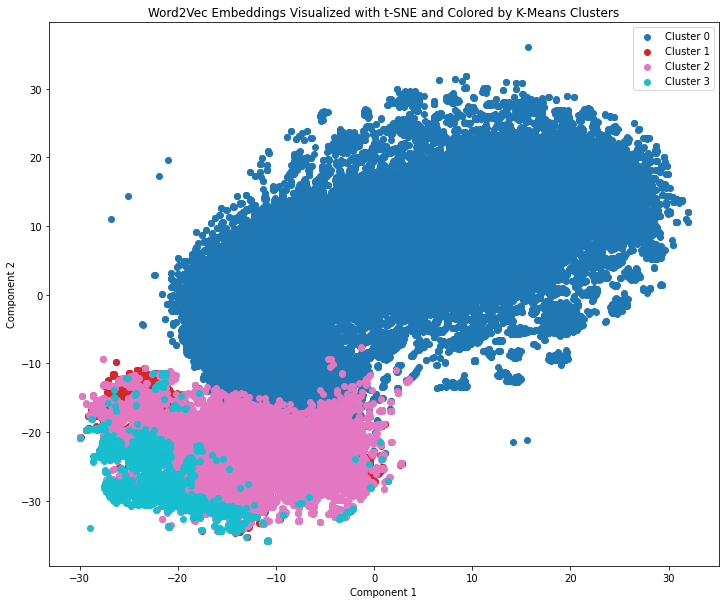

In [409]:
words = np.random.choice(list(sub_df_word2vec.wv.index_to_key), len(list(sub_df_word2vec.wv.index_to_key)), replace=False) 
word_vectors = np.array([sub_df_word2vec.wv[word] for word in words])

# Perform K-Means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(word_vectors)
cluster_labels = kmeans.labels_

# Set up t-SNE
tsne = TSNE(n_components=2, verbose=1, random_state=23)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Create a scatter plot of the t-SNE reduced word vectors, colored by cluster assignment
plt.figure(figsize=(12, 10))

# Generate a color map for the clusters
colors = plt.cm.get_cmap('tab10', num_clusters)

for i in range(num_clusters):
    # Select only data points that belong to the current cluster
    indices = [index for index, label in enumerate(cluster_labels) if label == i]
    current_cluster_vectors_2d = word_vectors_2d[indices]

    # Scatter plot for each cluster
    plt.scatter(current_cluster_vectors_2d[:, 0], current_cluster_vectors_2d[:, 1], c=[colors(i)], label=f'Cluster {i}')

plt.title('Word2Vec Embeddings Visualized with t-SNE and Colored by K-Means Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend() 
plt.show()


#### Still hard to put a label on the clusters, but also better than the previous model it seems ! 

### Let's try to do some summarization for fun :

### Summarization using BART pre-trained

In [140]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the pre-trained BART model and tokenizer
model_name = 'facebook/bart-large-cnn'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

def summarize(text):
    # Encode the text and get the generated summary
    inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

C:\Users\timot\anaconda3\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\timot\.cache\huggingface\hub\models--facebook--bart-large-cnn. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

#### Saving the model

In [326]:
#model.save_pretrained('D:/s9/NLP/project2_app/NLP_project2_app/saved_bart_model')
#tokenizer.save_pretrained('D:/s9/NLP/project2_app/NLP_project2_app/saved_bart_model')

('D:/s9/NLP/project2_app/NLP_project2_app/saved_bart_model\\tokenizer_config.json',
 'D:/s9/NLP/project2_app/NLP_project2_app/saved_bart_model\\special_tokens_map.json',
 'D:/s9/NLP/project2_app/NLP_project2_app/saved_bart_model\\vocab.txt',
 'D:/s9/NLP/project2_app/NLP_project2_app/saved_bart_model\\added_tokens.json',
 'D:/s9/NLP/project2_app/NLP_project2_app/saved_bart_model\\tokenizer.json')

future loading

In [327]:
#model = BartForConditionalGeneration.from_pretrained('saved_bart_model')
#tokenizer = BartTokenizer.from_pretrained('saved_bart_model')

### Trying out the summarization (this process took hours to complete)

In [141]:
book_df['summary_summary'] = book_df['cleaned_summary'].apply(summarize)

In [148]:
book_df['summary_summary'].iloc[10]

'Harvard symbologist Robert Langdon is awakened by a phone call in the dead of the night. The elderly curator of the Louvre has been murdered inside the museum. Langdon and gifted French cryptologist Sophie Neveu sort through the bizarre riddles.'

In [147]:
book_df['cleaned_summary'].iloc[10]

'ISBN 9780307277671 moved to this edition.While in Paris, Harvard symbologist Robert Langdon is awakened by a phone call in the dead of the night. The elderly curator of the Louvre has been murdered inside the museum, his body covered in baffling symbols. As Langdon and gifted French cryptologist Sophie Neveu sort through the bizarre riddles, they are stunned to discover a trail of clues hidden in the works of Leonardo da Vinci—clues visible for all to see and yet ingeniously disguised by the painter.Even more startling, the late curator was involved in the Priory of Sion—a secret society whose members included Sir Isaac Newton, Victor Hugo, and Da Vinci—and he guarded a breathtaking historical secret. Unless Langdon and Neveu can decipher the labyrinthine puzzle—while avoiding the faceless adversary who shadows their every move—the explosive, ancient truth will be lost forever.'

### The models effectively shortens the default summary, not bad !

## TF-IDF for book recommendation based on similarity

In [145]:
#file_path = 'D:/s9/NLP/projet3/goodreads_reviews/1000_best_books_summary.csv'

# Save the DataFrame to a CSV file
#book_df.to_csv(file_path, index=False)

### Loading the vectorizer, then fitting on the summaries

In [460]:
book_df['cleaned_summary_tokenized'] = book_df['cleaned_summary'].apply(clean_text)

In [461]:
tfidf_vectorizer_similar_book_optimized = TfidfVectorizer(stop_words='english')
tfidf_matrix_similar_book_optimized = tfidf_vectorizer_similar_book_optimized.fit_transform(book_df['cleaned_summary_tokenized'])

In [419]:
#joblib.dump(tfidf_vectorizer_similar_book, 'D:/s9/NLP/project2_app/NLP_project2_app/tfidf_vectorizer_similar_book.joblib')

['D:/s9/NLP/project2_app/NLP_project2_app/tfidf_vectorizer_similar_book.joblib']

In [329]:
#tfidf_vectorizer_similar_book_optimized = joblib.load('tfidf_vectorizer.joblib')

In [463]:
# Function to vectorize the user input 
def transform_query_tokenized(query):
    query = clean_text(query)
    query_tfidf = tfidf_vectorizer_similar_book_optimized.transform([query])
    return query_tfidf

#### Finding the closest summaries to the query by cosine similarity in the top 1000 books summaries, then displaying the name of the books, the similarity and the summary

the used summary is the sulmmary generated by the BART model from before, which is shorter and quick to read

In [467]:
def find_similar_books_tokenized(query, tfidf_matrix, book_names, book_summaries, top_n):
    query_tfidf = transform_query_tokenized(query)
    cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
    related_docs_indices = cosine_similarities.argsort()[:-top_n-1:-1]
    return [(book_names[i], cosine_similarities[i], book_summaries[i]) for i in related_docs_indices]

In [475]:
book_df.head(1)

,book_name,average_rating,review_sentiment,cleaned_summary,book_summary_cleaned,summary_summary,name_vector,tokenized_name,book_summary_cleaned_no_ponct,book_summary_cleaned_pour_de_vrai,cleaned_summary_tokenized
0,Harry Potter and the Half-Blood Prince,4.58,9.368922,"It is the middle of the summer, but there is a...","[It, is, the, middle, of, the, summer, ,, but,...",Harry Potter is waiting nervously in his bedro...,"[-0.80485755, 0.5509722, -0.10115806, 0.535483...","[harry, potter, and, the, half-blood, prince]","[middle, summer, unseasonal, mist, pressing, w...",middle summer unseasonal mist pressing windowp...,middle summer unseasonal mist pressing windowp...


#### Then we test the model

In [162]:
user_query = "a book about wizards"
recommended_books = find_similar_books_tokenized(user_query, tfidf_matrix_similar_book_optimized, book_df['book_name'], book_df['summary_summary'], 3)

for book, score, summary in recommended_books:
    print(f"Recommended Book: {book}\nScore: {score}")
    print(f"Summary: {summary}\n")

Recommended Book: Fantastic Beasts and Where to Find Them
Score: 0.17752610238959593
Summary: A copy of Fantastic Beasts and Where to Find Them resides on almost every wizarding household in the country. Now, for a limited period only, Muggles too have the chance to discover where the Quintaped lives. Proceeds from the sale of this book will go to improving and saving the lives of children around the world.

Recommended Book: The Demon King
Score: 0.16017993361058674
Summary: Reformed thief Han Alister will do almost anything to eke out a living for his family. Raisa ana'Marianna, princess heir of the Fells, has her own battles to fight. The Seven Realms tremble when the lives of Hans and Raisa collide.

Recommended Book: Harry Potter and the Sorcerer's Stone
Score: 0.1416414074935895
Summary: Harry Potter has no idea how famous he is. That's because he's being raised by his miserable aunt and uncle who are terrified Harry will learn that he's really a wizard, just as his parents were.

### The results are great ! The model looks to be performing as we intend.

## Question answering

In [181]:
# Load the pre-trained DistilBERT QA model
qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad", tokenizer="distilbert-base-uncased-distilled-squad")


config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

C:\Users\timot\anaconda3\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\timot\.cache\huggingface\hub\models--distilbert-base-uncased-distilled-squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [331]:
QA_BART_model = qa_pipeline.model
QA_BART_tokenizer = qa_pipeline.tokenizer

In [333]:
#QA_BART_model.save_pretrained('D:/s9/NLP/project2_app/NLP_project2_app/saved_distilbert_qa_model')
#QA_BART_tokenizer.save_pretrained('D:/s9/NLP/project2_app/NLP_project2_app/saved_distilbert_qa_model')

('D:/s9/NLP/project2_app/NLP_project2_app/saved_distilbert_qa_model\\tokenizer_config.json',
 'D:/s9/NLP/project2_app/NLP_project2_app/saved_distilbert_qa_model\\special_tokens_map.json',
 'D:/s9/NLP/project2_app/NLP_project2_app/saved_distilbert_qa_model\\vocab.txt',
 'D:/s9/NLP/project2_app/NLP_project2_app/saved_distilbert_qa_model\\added_tokens.json',
 'D:/s9/NLP/project2_app/NLP_project2_app/saved_distilbert_qa_model\\tokenizer.json')

loading later with

In [ ]:
#model = DistilBertForQuestionAnswering.from_pretrained('saved_distilbert_qa_model')
#tokenizer = DistilBertTokenizer.from_pretrained('saved_distilbert_qa_model')

# Reconstruct the pipeline
#qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

In [182]:
# Define the function so the model gets the context and question
def answer_question(question, context):
    result = qa_pipeline({'question': question, 'context': context})
    return result['answer']

#### Here we're implementing a tf-idf so if the user misspells a book name it looks automatically in the book names column to closest names from the input, and asks the user if he meant other book names

In [231]:
new_tfidf_vectorizer = TfidfVectorizer()
new_tfidf_matrix = new_tfidf_vectorizer.fit_transform(book_df['book_name'])

In [330]:
#joblib.dump(new_tfidf_vectorizer, 'D:/s9/NLP/project2_app/NLP_project2_app/QA_tfidf_vectorizer.joblib')

['D:/s9/NLP/project2_app/NLP_project2_app/QA_tfidf_vectorizer.joblib']

In [232]:
# Function for finding the closest book to user missinput by cosine similarity
def find_closest_books(input_name, new_tfidf_matrix, top_n=3):
    # Vectorize the input using the same TF-IDF vectorizer
    input_vector = new_tfidf_vectorizer.transform([input_name])

    # Compute cosine similarity between the input and all book names
    cosine_similarities = cosine_similarity(input_vector, new_tfidf_matrix).flatten()

    # Get the indices of the top_n closest books
    closest_indices = np.argsort(-cosine_similarities)[:top_n]

    # Get the names of the top_n closest books
    closest_books = book_df['book_name'].iloc[closest_indices].tolist()
    return closest_books


### Function to have the back and forth question/answer from the user with the model

In [240]:
def interactive_qa_t5(df):
    while True:
        book_name = input("Enter a book name to ask about (or 'exit' to quit): ").strip()
        if book_name.lower() == 'exit':
            break

        if book_name not in df['book_name'].values:
            closest_books = find_closest_books(book_name, new_tfidf_matrix, top_n=5)
            print("Did you mean one of these books?")
            for name in closest_books:
                print(f"- {name}")
            book_name = input("Please enter the correct book name (or 'exit' to quit): ").strip()
            if book_name.lower() == 'exit':
                break

        if book_name in df['book_name'].values:
            summary = df[df['book_name'] == book_name]['cleaned_summary'].iloc[0]
            question = input("What is your question about the book? ")
            answer = answer_question(question, summary)
            print(f"Answer: {answer}\n")
        else:
            print("Book not found. Please try again.\n")

### Example interaction

In [243]:
# Run the interactive QA
interactive_qa_t5(book_df)

Enter a book name to ask about (or 'exit' to quit): little woman
Did you mean one of these books?
- A Little Life
- The Little Prince
- How to Be a Woman
- The Woman in Cabin 10
- Little Women
Please enter the correct book name (or 'exit' to quit): 
Book not found. Please try again.

Enter a book name to ask about (or 'exit' to quit): Little Women
What is your question about the book? Where does the story take place?
Answer: New England

Enter a book name to ask about (or 'exit' to quit): Little Women
What is your question about the book? Who is the main character
Answer: Jo, tragically frail Beth, beautiful Meg, and romantic, spoiled Amy

Enter a book name to ask about (or 'exit' to quit): Is it a book made for children?
Did you mean one of these books?
- This Is Where It Ends
- Made You Up
- Miss Peregrine's Home for Peculiar Children
- The Book Thief
- The Graveyard Book
Please enter the correct book name (or 'exit' to quit): exit
